In [431]:
# Preparing a Quantum State using Qiskit Framework
# Basically, Implementation of the paper : https://arxiv.org/pdf/quant-ph/0407010
import numpy as np
import math
import pennylane as qml
from qiskit import QuantumCircuit
from qiskit.visualization import *

In [432]:
# Generates the Gray code of given rank
def graycode(rank):
    # Rank = Integer
    def gray_code_recurse(g, rank):
        k = len(g)
        
        if rank <= 0:
            return
        for i in range(k - 1, -1, -1):
            char = "1" + g[i]
            g.append(char)
        for i in range(k - 1, -1, -1):
            g[i] = "0" + g[i]
        gray_code_recurse(g, rank - 1)
        
    g = ["0", "1"]
    gray_code_recurse(g, rank - 1)
    
    return g

In [433]:
# Function that provides us with gray code of input Integer
def gray(n):
    # n = Integer
    n ^= (n >> 1)
    return bin(n)[2:]

# Function that gives dot product of binary array of integer i and gray code array of integer j
def dotP(i,j):
    binary = np.unpackbits(np.array([int(np.binary_repr(i),2)],dtype=np.uint8))
    gcode = np.unpackbits(np.array([int(gray(j),2)],dtype=np.uint8))
    
    sum1s = np.dot(binary,gcode)
    return sum1s

In [434]:
# Maps the angles alpha of the multi-controlled rotations decomposition of a uniformly controlled rotation 
# to the rotation angles theta used in the Gray code implementation
def compute_theta(alpha):
    # Alpha = numpy Array
    k = np.log2(len(alpha))
    N = int(2**k)
    
    M = np.empty((N,N))
    for i in range(N):
        for j in range(N):
            M[i,j] = (1/2**(k))*((-1)**dotP(j,i))
            
    theta = np.matmul(M,alpha)
    return theta # numpy Array

In [435]:
# Here, we compute the array of angles AlphaZ using the Equation (5), from the paper
def alpha_z(omega, n, k):
    # omega = phases of the desired state (Array)
    # n = total Qubits for Uniformly Controlled Rotation
    # k = index of Target Qubit
    alpha = []
    for j in range(2**(n-k)):
        angle = 0
        
        for l in range(2**(k-1)):
            angle = angle + (omega[(2*(j+1)-1)*(2**(k-1))+(l)] - omega[(2*(j+1)-2)*(2**(k-1))+(l)])/(2**(k-1))
            
        alpha.append(angle)
    return alpha # numpy Array

In [436]:
# This function computes the array of angles AlphaY using the Equation (8), from the paper
def alpha_y(a, n, k):
    # a = absolute values of the desired state
    # n = total Qubits for Uniformly Controlled Rotation
    # k = index of Target Qubit
    alpha = []
    for j in range(2**(n-k)):
        num = 0
        denom = 0
        
        for l in range(2**(k-1)):
            num = num + abs(a[(2*(j+1)-1)*(2**(k-1))+l])**2
            
        for l in range(2**k):
            denom = denom + abs(a[j*(2**k)+l])**2
            
        angle = 2*(math.asin(np.sqrt(num/denom)))
        alpha.append(angle)
    return alpha # numpy Array

In [437]:
# Here, we create an uniformly controlled RY rotation gate
def rotation_y(alpha, control_q, target_q):
    # alpha = angles to decompose the uniformly-controlled rotation into multi-controlled rotations (Array)
    # control_q = Array of control qubits
    # target_q = index of target qubit
    
    qc = QuantumCircuit(len(control_q)+1)
    theta = compute_theta(alpha)
    gray_code_rank = len(control_q)
    
    if gray_code_rank == 0:
        if theta[0] != 0.0:
            qc.ry(theta[0], target_q)
        return qc
    
    code = graycode(gray_code_rank)
    num_selections = len(code)

    control_indices = [int(np.log2(int(code[i], 2) ^ int(code[(i + 1) % num_selections], 2))) for i in range(num_selections)]

    for i, control_index in enumerate(control_indices):
        if theta[i] != 0.0:
            qc.ry(theta[i], target_q)
        qc.cx(control_q[control_index], target_q)
    return qc

In [438]:
# Here, we create an uniformly controlled RZ rotation gate
def rotation_z(alpha, control_q, target_q):
    # alpha = angles to decompose the uniformly-controlled rotation into multi-controlled rotations (Array)
    # control_q = Array of control qubits
    # target_q = index of target qubit
    
    qc = QuantumCircuit(len(control_q)+1)
    theta = compute_theta(alpha)
    gray_code_rank = len(control_q)
    
    if gray_code_rank == 0:
        if theta[0] != 0.0:
            qc.rz(theta[0], target_q)
        return qc
    
    code = graycode(gray_code_rank)
    num_selections = len(code)

    control_indices = [int(np.log2(int(code[i], 2) ^ int(code[(i + 1) % num_selections], 2))) for i in range(num_selections)]

    for i, control_index in enumerate(control_indices):
        if theta[i] != 0.0:
            qc.rz(theta[i], target_q)
        qc.cx(control_q[control_index], target_q)
    return qc

In [439]:
# Creates the Circuit which eventually provides us with Desired StateVector
# Prepares an arbitrary state on the given wires using a decomposition into gates developed
# by `Möttönen et al. (2004) <https://arxiv.org/abs/quant-ph/0407010>

def initialize_state(state, qubits):
    
    state = state / np.linalg.norm(state)
    a = np.absolute(state)
    omega = np.angle(state)
    qubits_rev = qubits[::-1]
    qc = QuantumCircuit(len(qubits))

        # Apply inverse y rotation cascade to prepare correct absolute values of amplitudes
    for k in range(len(qubits_rev), 0, -1):
        alpha_y_k = alpha_y(a, len(qubits_rev), k)
        control = qubits_rev[k:]
        target = qubits_rev[k - 1]
        qc = qc.compose(rotation_y(alpha_y_k, control, target))

        # If necessary, apply inverse z rotation cascade to prepare correct phases of amplitudes
    if not qml.math.allclose(omega, 0):
        for k in range(len(qubits_rev), 0, -1):
            alpha_z_k = alpha_z(omega, len(qubits_rev), k)
            control = qubits_rev[k:]
            target = qubits_rev[k - 1]
            if len(alpha_z_k) > 0:
                qc = qc.compose(rotation_z(alpha_z_k, control, target))
                
    return qc

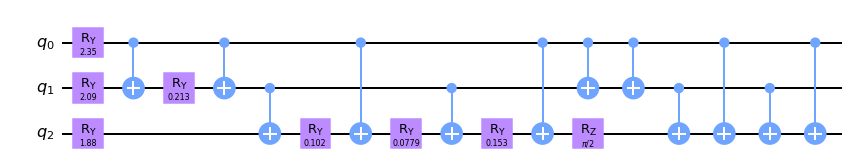

In [440]:
# Quantum Circuit
state = [1, 2j, 3, 4j, 5, 6j, 7, 8j]
qc = initialize_state(state,[0,1,2])
qc.draw()